In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.model_selection import train_test_split

In [7]:
torch.manual_seed(42)

# Dataset

In [8]:
progeria = pd.read_csv(r"230705_progeria_c2/progeria_3objs.csv",index_col=0)
normal = pd.read_csv(r"230705_normal_c2/normal_3objs.csv",index_col=0)
cols_to_drop = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
size_based = ["AreaShape_Area","AreaShape_Perimeter", "AreaShape_BoundingBoxArea", "AreaShape_BoundingBoxMaximum_X", "AreaShape_BoundingBoxMaximum_Y", "AreaShape_BoundingBoxMinimum_X", "AreaShape_BoundingBoxMinimum_Y", "AreaShape_ConvexArea", "AreaShape_EquivalentDiameter", "AreaShape_MajorAxisLength", "AreaShape_MinorAxisLength", "AreaShape_MaxFeretDiameter", "AreaShape_MinFeretDiameter", "AreaShape_MaximumRadius", "AreaShape_MeanRadius", "AreaShape_MedianRadius"]
posn_based = ["AreaShape_Center_X", "AreaShape_Center_Y", "Location_Center_X","Location_Center_Y", "Location_Center_Z"]
					
progeria = progeria.assign(label=1) 
normal = normal.assign(label=0) 
full_data_allcol = pd.concat([progeria, normal],axis=0)
full_data_allcol = full_data_allcol.replace([np.inf, -np.inf], np.nan)
full_data_allcol = full_data_allcol.dropna()
full_data = full_data_allcol.drop(columns=cols_to_drop + size_based + posn_based)
n_cells, n_feats = np.shape(full_data)

In [466]:
class CellFeaturesDataset(Dataset):
    def __init__(self, fulldata, transform=None, target_transform=None):
        self.labels = fulldata.loc[:,'label'].values
        self.source_image = full_data_allcol.loc[:,'ImageNumber'].values
        self.data = fulldata.loc[:,~fulldata.columns.isin(['label'])].values
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data[idx,:]
        label = self.labels[idx]
        source_image = self.source_image[idx]
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            label = self.target_transform(label)
        return item.float(), label.float()

## Transform data - scale and convert to tensor

In [467]:
def tensor_and_scale (x):
    m = x.mean(0)
    s = x.std(0)
    x -= m
    x /= s
    # torch.allclose(x, torch.from_numpy(arr_norm))
    return torch.as_tensor(x)

t = tensor_and_scale

In [468]:
cell_dataset = CellFeaturesDataset(full_data, transform=t, target_transform=torch.as_tensor)

## Train-test split, create dataloaders

In [552]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
split, split1 = gss.split(X=cell_dataset, y=cell_dataset.labels, groups=cell_dataset.source_image)
train_idx, test_idx = split
train_cells = torch.utils.data.Subset(cell_dataset, train_idx)
test_cells = torch.utils.data.Subset(cell_dataset, test_idx)

In [559]:
train_cells[0]

(tensor([-0.0256, -0.0929, -0.0600, -0.1047, -0.0872,  5.9940, -0.0656, -0.1073,
         -0.1734, -0.1735, -0.1827, -0.1860, -0.1877, -0.1890, -0.1878, -0.1882,
         -0.1870, -0.1895, -0.1894, -0.1883, -0.1895, -0.1893, -0.1892, -0.1902,
         -0.1891, -0.1899, -0.1904, -0.1903, -0.1902, -0.1901, -0.1900, -0.1896,
         -0.1903, -0.1899, -0.1898, -0.1902, -0.1903]),
 tensor(1.))

In [578]:
from collections import Counter

print(Counter([int(x[1].item()) for x in train_cells]))
normal_wt = Counter([int(x[1].item()) for x in train_cells])[0]/len(train_cells)
progeria_wt = 1 - normal_wt
print(normal_wt, progeria_wt)

Counter({1: 88, 0: 79})
0.47305389221556887 0.5269461077844311


In [579]:
batch_size = 30

#sampler = torchsample.StratifiedSampler(class_vector=cell_dataset.labels, batch_size=batch_size)
#test_cells, train_cells = torch.utils.data.random_split(cell_dataset, [.3, .7])
train_dataloader = DataLoader(train_cells, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_cells, batch_size=batch_size, shuffle=True)

# ANN

In [527]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        # self.flatten = nn.Flatten()
        mid = (n_inputs+n_outputs)//2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=mid),
            nn.ReLU(),
            nn.Linear(in_features=mid, out_features=n_outputs),
        )
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)

        #self.linear_relu_stack.apply(init_weights)

    def forward(self, x):
        # do stuff here
        logits = self.linear_relu_stack(x)
        probs = torch.sigmoid(logits)
        return logits

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [378]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.float()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        y_hat = model(X)
        loss = loss_fn(y_hat[:,1], y.float())
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [379]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    model.float()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            y_hat = model(X)
            predicted = torch.max(y_hat.data, 1)[1]
            test_loss += loss_fn(y_hat[:,1], y.float()).item()
            ncorr = predicted == y
            print(predicted)
            print(y)
            correct += sum(ncorr)
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    test_loss /= num_batches
    bal_acc /= num_batches
    correct = correct/size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return 100*correct, bal_acc, test_loss

## Run

In [404]:
learning_rate = 1e-2
epochs = 70
# weight=torch.as_tensor([progeria_wt])
loss_fn = nn.BCEWithLogitsLoss()
# reg_fn = nn.L1Loss()
model = NeuralNetwork(n_feats-1, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
opt2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l = train(train_dataloader, model, loss_fn, opt2)
    a, b_a, t_l = test(test_dataloader, model, loss_fn)
    losses.append(l)
    accs.append(a)
    bal_accs.append(b_a)
    test_losses.append(t_l)
print("Done!")

Epoch 1
-------------------------------
loss: 0.702636  [   30/  156]
loss: 0.690820  [   60/  156]
loss: 0.699309  [   90/  156]
loss: 0.692065  [  120/  156]
loss: 0.691555  [  150/  156]
loss: 0.709175  [   36/  156]
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0.])
Test Error: 
 Accuracy: 50.0%, Avg. balanced accuracy: 0.5, Avg loss: 0.690875 

Epoch 2
---------

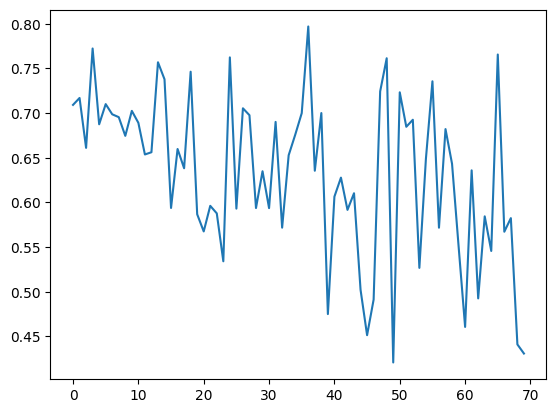

In [405]:
plt.plot(losses)

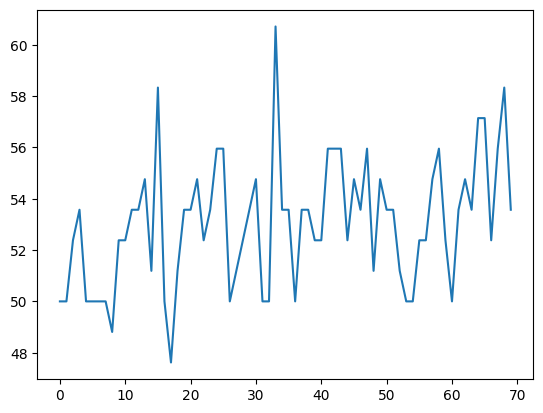

In [406]:
plt.plot(accs)

# Logistic regression

In [580]:
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        # torch.nn.init.uniform_(self.linear.weight, -0.01, 0.01) 
        # torch.nn.init.zeros_(self.linear.bias)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [581]:
def train (dataloader, model, loss_fn, optimizer, use_closure = False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X)
        # loss = None
        if use_closure:
            def closure():
                optimizer.zero_grad()
                y_hat = model(X)
                loss = loss_fn(y_hat[:,1], y.float())
                loss.backward()
                return loss
            loss = closure()
            optimizer.step(closure)
        else:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = loss_fn(y_hat[:,1], y.float())
            loss.backward()
            optimizer.step()
        current = (batch + 1) * len(X)
        print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(loss.item())
    return loss.item()

In [582]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, bal_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            _, predicted = torch.max(y_hat.data, 1)
            print(predicted)
            print(y)
            test_loss += loss_fn(y_hat[:,1], y.float()).item()
            correct += (predicted == y).sum()
            bal_acc += torchmetrics.functional.classification.accuracy(predicted, y.long(), task='multiclass', num_classes=2, average='macro') 
    accuracy = 100 * (correct) / len(dataloader.dataset)
    test_loss /= num_batches
    bal_acc /= num_batches
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg. balanced accuracy: {(bal_acc):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return accuracy, bal_acc, test_loss

## Run

In [606]:
log_regr = LogisticRegression(n_feats-1, 2)
# could use BCEWithLogitsLoss and pos_weight
loss_fn = torch.nn.BCELoss()
learning_rate = .05
# optimizer = torch.optim.SGD(log_regr.parameters(), lr=learning_rate)
opt2 = torch.optim.Adam(log_regr.parameters(), lr=learning_rate)
# opt3 = torch.optim.LBFGS(log_regr.parameters(), lr=learning_rate, max_iter=100)
epochs = 50

losses = []
accs = []
bal_accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l_t = train(train_dataloader, log_regr, loss_fn, opt2, use_closure=True)
    a_t, b_a, tl_t = test(test_dataloader, log_regr, loss_fn)
    losses.append(l_t)
    accs.append(a_t)
    bal_accs.append(b_a)
    test_losses.append(tl_t)
print("Done!")

Epoch 1
-------------------------------
loss: 0.676324  [   30/  167]
loss: 0.732528  [   60/  167]
loss: 0.699132  [   90/  167]
loss: 0.792488  [  120/  167]
loss: 0.665388  [  150/  167]
loss: 0.788082  [  102/  167]
0.7880819439888
tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0])
tensor([1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
Test Error: 
 Accuracy: 45.2%, Avg. balanced accuracy: 0.4, Avg loss: 0.708259 

Epoch 2
-------------------------------
loss: 0.691181  [   30/  167]
loss: 0.713686  

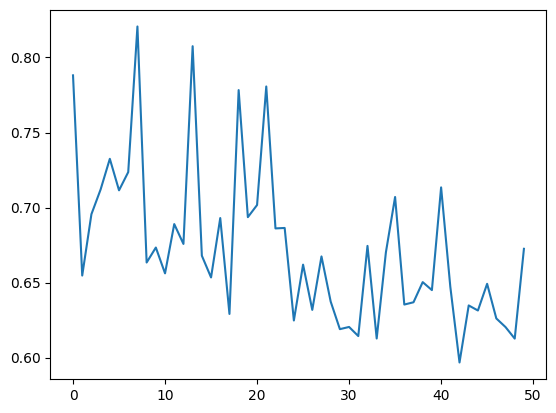

In [607]:
plt.plot(losses)

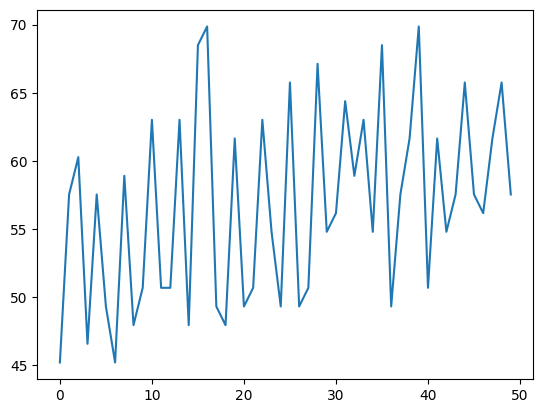

In [608]:
plt.plot(accs)

# Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

X_train = np.asarray([x[0].numpy() for x in train_cells])
y_train = np.asarray([x[1].item() for x in train_cells])

X_test = np.asarray([x[0].numpy() for x in test_cells])
y_test = np.asarray([x[1].item() for x in test_cells])

NameError: name 'train_cells' is not defined

In [807]:
print(Counter(y_test))

Counter({0.0: 41, 1.0: 32})


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

random_grid = {'n_estimators': list(range(2,50,1)),
               'max_features': [None, 'log2', 'sqrt'],
               'criterion':['log_loss'],
               'max_depth': list(range(2,10)),
               'bootstrap': [True,False],
               'class_weight': ["balanced"]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2)
rf_grid.fit(X_train,y_train)

In [823]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 3, 'max_features': None, 'n_estimators': 35}
0.7725108225108225


[Zernike features](https://static.wixstatic.com/media/6454f7_05033456d02d4514bb23cd88e4056f3b~mv2.png/v1/fit/w_528%2Ch_623%2Cal_c%2Cq_80,enc_auto/file.jpg)

In [4]:
from sklearn import metrics
clf_base = RandomForestClassifier(n_estimators=53,max_depth=9, criterion="log_loss", random_state=42, class_weight="balanced",bootstrap=True)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)
y_pred_grid = rf_grid.best_estimator_.predict(X_test)

print(metrics.balanced_accuracy_score(y_test,y_pred_base))
print(metrics.balanced_accuracy_score(y_test,y_pred_grid))

print(pd.Series(dict(zip(full_data.columns,clf_base.feature_importances_))).sort_values(ascending=False).head(20))

NameError: name 'RandomForestClassifier' is not defined

In [826]:
from sklearn import metrics
clf_base = RandomForestClassifier(n_estimators=22,max_depth=2, criterion="log_loss", random_state=42, class_weight="balanced",bootstrap=True)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)
y_pred_grid = rf_grid.best_estimator_.predict(X_test)

print(metrics.balanced_accuracy_score(y_test,y_pred_base))
print(metrics.balanced_accuracy_score(y_test,y_pred_grid))

0.6017530487804879
0.6208079268292683


In [822]:
print(pd.Series(dict(zip(full_data.columns,clf_base.feature_importances_))).sort_values(ascending=False).head(10))
print(pd.Series(dict(zip(full_data.columns,rf_grid.best_estimator_.feature_importances_))).sort_values(ascending=False).head(10))

AreaShape_Zernike_2_0     0.158860
AreaShape_Eccentricity    0.065707
AreaShape_Zernike_0_0     0.058102
AreaShape_Zernike_1_1     0.052545
AreaShape_Zernike_4_0     0.051644
AreaShape_FormFactor      0.048617
AreaShape_Zernike_2_2     0.041149
AreaShape_Compactness     0.037374
AreaShape_EulerNumber     0.033669
AreaShape_Extent          0.026366
dtype: float64
AreaShape_Zernike_2_0     0.461670
AreaShape_Zernike_0_0     0.105726
AreaShape_Zernike_4_0     0.095751
AreaShape_Zernike_1_1     0.090849
AreaShape_Compactness     0.079250
AreaShape_Eccentricity    0.046735
AreaShape_FormFactor      0.024043
AreaShape_Orientation     0.019132
AreaShape_EulerNumber     0.013335
AreaShape_Zernike_2_2     0.011507
dtype: float64


In [266]:
# https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/


# XGBoost

In [610]:
from xgboost import XGBClassifier

X_train = np.asarray([x[0].numpy() for x in train_cells])
y_train = np.asarray([x[1].item() for x in train_cells])

X_test = np.asarray([x[0].numpy() for x in test_cells])
y_test = np.asarray([x[1].item() for x in test_cells])


In [645]:
import sklearn

In [657]:
bst = XGBClassifier(n_estimators=60, max_depth=None, learning_rate=.5, objective='binary:logistic', eval_metric=sklearn.metrics.balanced_accuracy_score)
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)
print(f"acc: {np.sum([preds==y_test])/len(y_test)}")
print(f"bal acc: {sklearn.metrics.balanced_accuracy_score(y_test,preds)}")

acc: 0.6027397260273972
bal acc: 0.6017530487804879


In [803]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

bst = xgb.train({'seed': 42, 'booster':'gblinear','objective':'reg:logistic'},  # any other tree method is fine.
           dtrain=dtrain,
           num_boost_round=50,)

In [804]:
dtest = xgb.DMatrix(X_test, label=y_test)

ypred =  bst.predict(dtest)
predictions = [round(x) for x in ypred]

In [805]:
print(f"acc: {np.sum([predictions==y_test])/len(y_test)}")
print(f"bal acc: {sklearn.metrics.balanced_accuracy_score(y_test,predictions)}")

acc: 0.6575342465753424
bal acc: 0.6814024390243902
